# Laboratorio 3

- José Prince
- Diego Linares

En este laboratorio se trabajará con el dataset de Kaggle: https://www.kaggle.com/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis/data. A continuación se muestra el contenido de los diferentes módulos que tiene el dataset a utilizar.


In [13]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import pyfiglet
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Rescaling
from collections import Counter
import numpy as np

            ___  
 _ __ ___  / _ \ 
| '_ ` _ \| | | |
| | | | | | |_| |
|_| |_| |_|\___/ 
                 



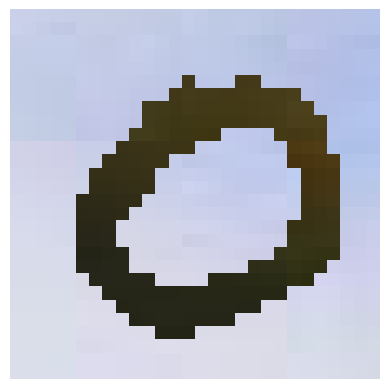

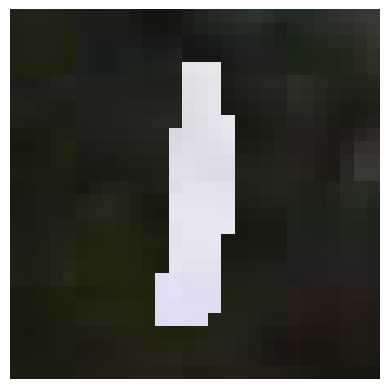

           _ 
 _ __ ___ / |
| '_ ` _ \| |
| | | | | | |
|_| |_| |_|_|
             



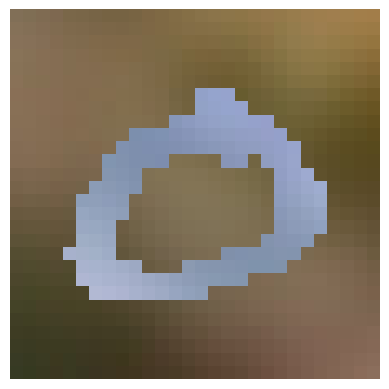

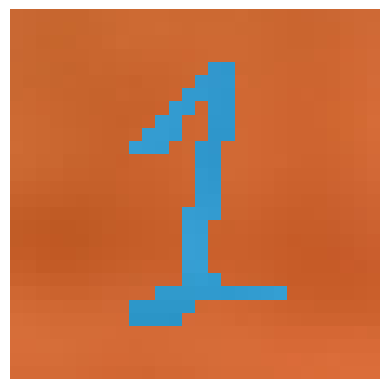

           ____  
 _ __ ___ |___ \ 
| '_ ` _ \  __) |
| | | | | |/ __/ 
|_| |_| |_|_____|
                 



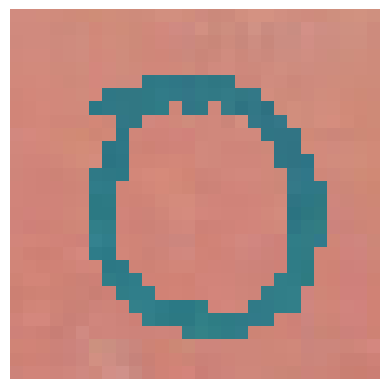

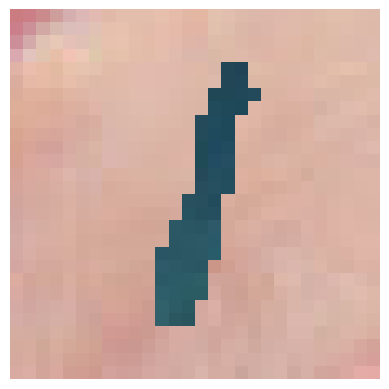

           _____ 
 _ __ ___ |___ / 
| '_ ` _ \  |_ \ 
| | | | | |___) |
|_| |_| |_|____/ 
                 



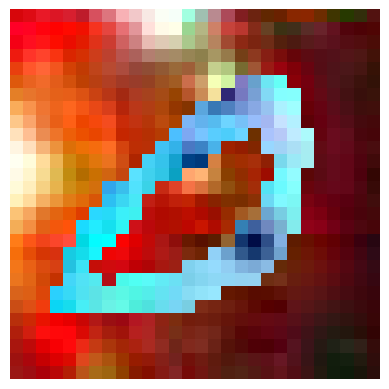

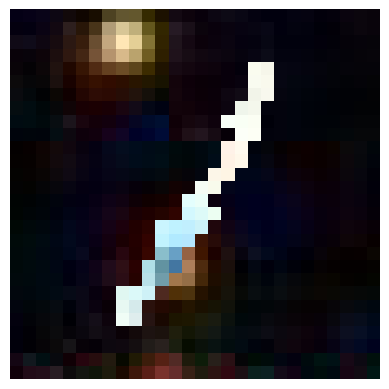

           _  _   
 _ __ ___ | || |  
| '_ ` _ \| || |_ 
| | | | | |__   _|
|_| |_| |_|  |_|  
                  



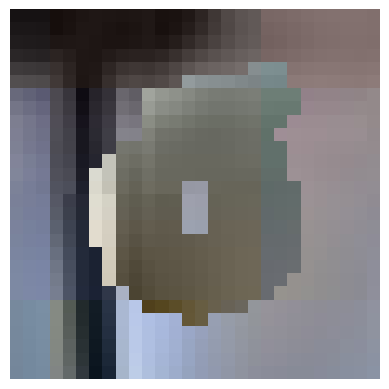

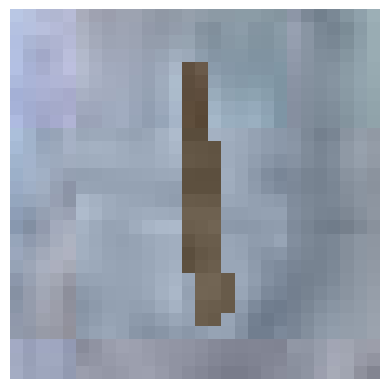

In [11]:
main_route = "./PolyMNIST/MMNIST/train/"

for i in range(5):
    module = "m" + str(i)
    route = main_route + module
    print(pyfiglet.figlet_format(module))
    if os.path.exists(route):
        images = [f for f in os.listdir(route) if f.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif"))]
        for img in images[:2]:
            img_route = os.path.join(route, img)
            try:
                image = Image.open(img_route)
                plt.imshow(image)
                plt.axis('off')
                plt.show()        
            except Exception as e:
                print(f"Error al cargar {img_route}: {e}")        

## Analisis exploratorio

Para el dataset que tenemos vamos a naalizar como estan distribuidas las diferentes clases e identificar si existe un desbalanceo. 

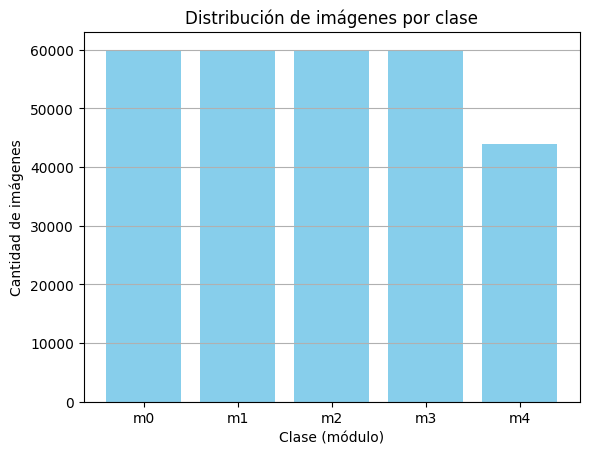

In [4]:
clases = sorted(os.listdir(main_route))

count = {}
for clase in clases:
    route = os.path.join(main_route, clase)
    if os.path.isdir(route):
        count[clase] = len([
            f for f in os.listdir(route)
            if f.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif"))
        ])

plt.bar(count.keys(), count.values(), color='skyblue')
plt.title("Distribución de imágenes por clase")
plt.xlabel("Clase (módulo)")
plt.ylabel("Cantidad de imágenes")
plt.grid(True, axis='y')
plt.show()

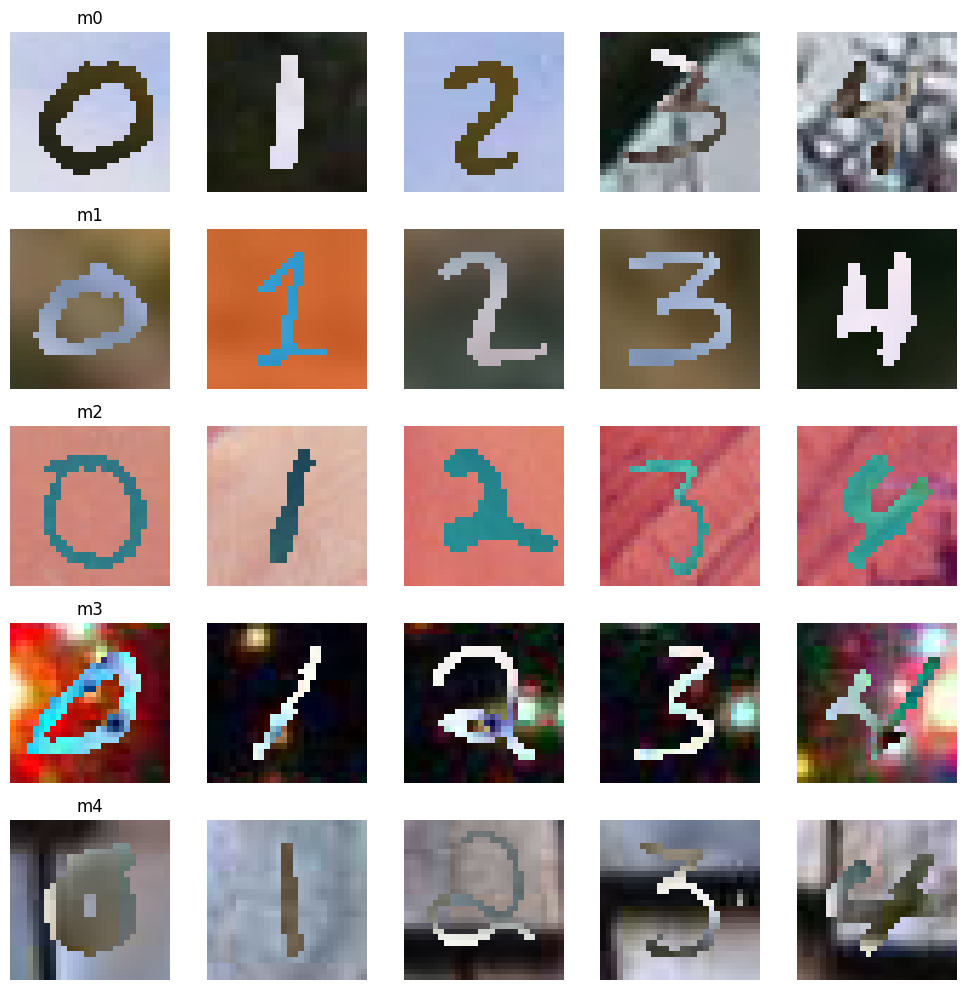

In [5]:

fig, axs = plt.subplots(len(clases), 5, figsize=(10, 10))
for i, clase in enumerate(clases):
    ruta_clase = os.path.join(main_route, clase)
    imagenes = [f for f in os.listdir(ruta_clase) if f.endswith((".png", ".jpg"))][:5]
    for j, imagen in enumerate(imagenes):
        ruta_img = os.path.join(ruta_clase, imagen)
        img = Image.open(ruta_img)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(clase)
plt.tight_layout()
plt.show()

In [ ]:
dimensiones = []
for clase in clases:
    ruta_clase = os.path.join(main_route, clase)
    for archivo in os.listdir(ruta_clase):
        if archivo.lower().endswith((".png", ".jpg", ".jpeg")):
            ruta_img = os.path.join(ruta_clase, archivo)
            try:
                with Image.open(ruta_img) as img:
                    dimensiones.append(img.size)  # (ancho, alto)
            except:
                pass

conteo_dim = Counter(dimensiones)
print("Tamaños más comunes:")
for dim, count in conteo_dim.most_common(5):
    print(f"{dim}: {count} imágenes")

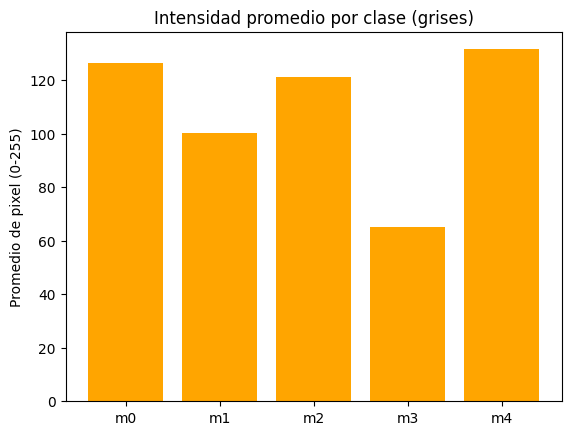

In [ ]:
promedios = {}

for clase in clases:
    ruta_clase = os.path.join(main_route, clase)
    intensidades = []
    for archivo in os.listdir(ruta_clase)[:100]:  # Limita si tienes muchas
        ruta_img = os.path.join(ruta_clase, archivo)
        try:
            with Image.open(ruta_img) as img:
                img = img.convert("L")  # Escala de grises para intensidad
                intensidades.append(np.array(img).mean())
        except:
            pass
    promedios[clase] = np.mean(intensidades)

# Visualizar
plt.bar(promedios.keys(), promedios.values(), color='orange')
plt.title("Intensidad promedio por clase (grises)")
plt.ylabel("Promedio de pixel (0-255)")
plt.show()


## Modelos CNN

### Primer modelo

Para el primer modelo de CNN se implemento utilizando Keras, este modelo tiene como proposito clasificar imágenes RGB que representan dígitos. Este carga las imágenes desde los diferentes modulos que hay para el entrenamiento. Las imágenes son redimiensionadas a 28x28 píxeles y normalizadas para facilitar el entrenamiento. La arquitectura consta de dos capas convolucionales seguidas de capas de max-pooling para la extracción de características, una cap densa intermedia y una capa de salida con activación softmax que aisgna probabilidaddes a cada una de las clases.

In [ ]:
train_dir = "./PolyMNIST/MMNIST/train/"
 
img_size = (28, 28)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True,
    seed=42
)

val_ds = train_ds.take(100)
train_ds = train_ds.skQip(100)

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(28, 28, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

loss, acc = model.evaluate(val_ds)
print(f"\nPrecisión en validación: {acc * 100:.2f}%")

Found 283961 files belonging to 5 classes.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,181 (477.27 KB)

 Trainable params: 122,181 (477.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 94s 11ms/step - accuracy: 0.9641 - loss: 0.0906 - val_accuracy: 0.9828 - val_loss: 0.0471
Epoch 2/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 89s 10ms/step - accuracy: 0.9924 - loss: 0.0220 - val_accuracy: 0.9959 - val_loss: 0.0124
Epoch 3/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 85s 10ms/step - accuracy: 0.9956 - loss: 0.0139 - val_accuracy: 0.9969 - val_loss: 0.0096
Epoch 4/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 93s 11ms/step - accuracy: 0.9967 - loss: 0.0102 - val_accuracy: 0.9969 - val_loss: 0.0092
Epoch 5/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 77s 9ms/step - accuracy: 0.9972 - loss: 0.0085 - val_accuracy: 0.9981 - val_loss: 0.0045
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9978 - loss: 0.0047

Precisión en validación: 99.78%


### Segundo modelo



In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D,
    Dropout, Dense, BatchNormalization, InputLayer
)

img_size = (64, 64)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True,
    seed=42
)


input_shape = (64, 64, 3)
num_classes = 10

model2 = Sequential()
model2.add(InputLayer(input_shape=input_shape))

model2.add(SeparableConv2D(32, (3, 3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(SeparableConv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.3))

model2.add(SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.4))

model2.add(GlobalAveragePooling2D())

model2.add(Dense(num_classes, activation='softmax'))

model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()

history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Found 283961 files belonging to 5 classes.


c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d                │ (None, 64, 64, 32)     │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 32, 32, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 16, 16, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,637 (53.27 KB)

 Trainable params: 13,189 (51.52 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/5
8874/8874 ━━━━━━━━━━━━━━━━━━━━ 327s 37ms/step - accuracy: 0.9813 - loss: 0.0531 - val_accuracy: 0.6678 - val_loss: 3.3134
Epoch 2/5
8874/8874 ━━━━━━━━━━━━━━━━━━━━ 338s 38ms/step - accuracy: 0.9960 - loss: 0.0122 - val_accuracy: 0.5387 - val_loss: 8.1570
Epoch 3/5
8874/8874 ━━━━━━━━━━━━━━━━━━━━ 324s 36ms/step - accuracy: 0.9972 - loss: 0.0085 - val_accuracy: 0.5928 - val_loss: 3.3267
Epoch 4/5
8874/8874 ━━━━━━━━━━━━━━━━━━━━ 316s 36ms/step - accuracy: 0.9979 - loss: 0.0068 - val_accuracy: 0.5800 - val_loss: 3.6138
Epoch 5/5
8874/8874 ━━━━━━━━━━━━━━━━━━━━ 326s 37ms/step - accuracy: 0.9981 - loss: 0.0058 - val_accuracy: 0.6047 - val_loss: 2.8668


El escalar a 64×64 afectó al modelo

No añadió información real:

* El reescalado no genera nuevos detalles, solo estira los píxeles existentes.

* El modelo ahora procesa mucho más ruido.

Aumentó la complejidad innecesariamente:

* Cada imagen pasó de 784 píxeles (28×28) a 4096 píxeles (64×64).

* La red tuvo que aprender con más parámetros, lo que favoreció el sobreajuste.

Sin augmentation ni regularización fuerte:

* El modelo memoriza los patrones "ruidosos" en lugar de generalizar.

* Esto explica el train_acc ≈ 99.8% pero val_acc ≈ 60%.

## Modelo simple (MLP)

Este modelo no usa convoluciones, solo capas densas. Debemos aplanar las imágenes y entrenar.

In [ ]:
# Usamos las imágenes en 28x28 como en la primera CNN
train_dir = "./PolyMNIST/MMNIST/train/"
img_size = (28, 28)
batch_size = 32

train_ds_mlp = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True,
    seed=42
)

val_ds_mlp = train_ds_mlp.take(100)
train_ds_mlp = train_ds_mlp.skip(100)


Found 283961 files belonging to 5 classes.


In [16]:
# Normalizar y aplanar
normalization_layer = Rescaling(1./255)

model_mlp = Sequential([
    normalization_layer,
    Flatten(input_shape=(28,28,3)),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model_mlp.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model_mlp.summary()

history_mlp = model_mlp.fit(
    train_ds_mlp,
    validation_data=val_ds_mlp,
    epochs=5
)

loss_mlp, acc_mlp = model_mlp.evaluate(val_ds_mlp)
print(f" Precisión Red Neuronal Simple: {acc_mlp*100:.2f}%")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 114s 13ms/step - accuracy: 0.8402 - loss: 0.3715 - val_accuracy: 0.8988 - val_loss: 0.2379
Epoch 2/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 135s 15ms/step - accuracy: 0.8848 - loss: 0.2727 - val_accuracy: 0.9216 - val_loss: 0.1942
Epoch 3/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 103s 12ms/step - accuracy: 0.8953 - loss: 0.2511 - val_accuracy: 0.9303 - val_loss: 0.1852
Epoch 4/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 105s 12ms/step - accuracy: 0.9013 - loss: 0.2390 - val_accuracy: 0.9350 - val_loss: 0.1894
Epoch 5/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 100s 11ms/step - accuracy: 0.9060 - loss: 0.2298 - val_accuracy: 0.9381 - val_loss: 0.1644
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9391 - loss: 0.1644
 Precisión Red Neuronal Simple: 93.91%


## Modelo con Otro Algoritmo en este caso SVM

In [ ]:
from tensorflow.keras.models import Model
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

cnn_trained = model2  #  modelo entrenado de 64x64

# --- Obtener la penúltima capa de manera segura ---
penultima_capa = cnn_trained.layers[-2].name

# --- Crear extractor sin usar model2.input ---
feature_extractor = Model(
    inputs=cnn_trained.layers[0].input, 
    outputs=cnn_trained.get_layer(penultima_capa).output
)

# --- Extraer features de un subset (1000 batches) ---
x_features, y_labels = [], []
for img_batch, label_batch in train_ds.take(350):
    feats = feature_extractor.predict(img_batch, verbose=0)
    x_features.append(feats)
    y_labels.append(label_batch.numpy())

x_features = np.vstack(x_features)
y_labels = np.hstack(y_labels)

# --- Entrenar SVM ---
svm = SVC(kernel='rbf', C=10, gamma=0.01)

svm.fit(x_features, y_labels)

# --- Evaluar en val_ds ---
x_val, y_val = [], []
for img_batch, label_batch in val_ds.take(10):
    feats = feature_extractor.predict(img_batch, verbose=0)
    x_val.append(feats)
    y_val.append(label_batch.numpy())

x_val = np.vstack(x_val)
y_val = np.hstack(y_val)

y_pred = svm.predict(x_val)
print(f"Precisión SVM: {accuracy_score(y_val, y_pred)*100:.2f}%")


Precisión SVM: 50.00%


Modelo con otro algoritmo (SVM):
Se usó un Support Vector Machine (SVM) como clasificador, entrenado sobre los vectores de características extraídos de la penúltima capa de la CNN avanzada (model2).
El SVM intenta separar las clases usando una frontera no lineal (kernel RBF).
Aunque el modelo alcanzó un accuracy de aproximadamente 50%, el rendimiento fue inferior al de las CNN, debido a que los embeddings provenientes de model2 no eran suficientemente discriminativos y el SVM no escaló bien con el tamaño del dataset.

### Data Augmentation + CNN

El laboratorio pide probar con augmentación. Asi que, la haremos para el primer modelo nada mas..
Aquí usamos layers.Random... para generar variaciones en cada batch:

In [40]:
img_size = (28, 28)
batch_size = 32

train_ds_28 = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True,
    seed=42
)

val_ds_28 = train_ds_28.take(100)
train_ds_28 = train_ds_28.skip(100)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

aug_model = Sequential([
    data_augmentation,
    Rescaling(1./255, input_shape=(28,28,3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

aug_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history_aug = aug_model.fit(
    train_ds_28,
    validation_data=val_ds_28,
    epochs=5
)


loss_aug, acc_aug = aug_model.evaluate(val_ds)
print(f"Precisión con Data Augmentation: {acc_aug*100:.2f}%")


Found 283961 files belonging to 5 classes.
Epoch 1/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 107s 12ms/step - accuracy: 0.9592 - loss: 0.1016 - val_accuracy: 0.9819 - val_loss: 0.0463
Epoch 2/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 94s 11ms/step - accuracy: 0.9874 - loss: 0.0353 - val_accuracy: 0.9850 - val_loss: 0.0397
Epoch 3/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 120s 14ms/step - accuracy: 0.9918 - loss: 0.0245 - val_accuracy: 0.9881 - val_loss: 0.0305
Epoch 4/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 124s 14ms/step - accuracy: 0.9935 - loss: 0.0191 - val_accuracy: 0.9875 - val_loss: 0.0382
Epoch 5/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 96s 11ms/step - accuracy: 0.9944 - loss: 0.0168 - val_accuracy: 0.9859 - val_loss: 0.0429
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9856 - loss: 0.0432
Precisión con Data Augmentation: 98.56%


Una CNN (Convolutional Neural Network) utiliza capas convolucionales que:

* Aprenden filtros locales (3×3, 5×5, etc.) que detectan bordes, curvas, texturas.

* Estos filtros se aplican en toda la imagen (propiedad de traslación-invariante).

* Gracias a esto, la CNN entiende que un “2” sigue siendo un 2 aunque se rote un poco, se desplace o se escale.

Cuando se aplica Data Augmentation:

* Rotaciones, zoom y flips generan versiones del dígito en distintas posiciones/orientaciones.

* La CNN generaliza mejor porque aprende a reconocer el patrón sin importar el cambio.

* Esto se traduce en mayor robustez ante imágenes nuevas (como las manuscritas que pide el laboratorio probar).

Por eso tu CNN original (99.78%) con augmentation sigue alta (98.56%):

* Puede que el accuracy baje un poco,

* Pero gana capacidad de generalización.

### Versión del modelo simple (MLP) con augmentation

In [ ]:

# === Dataset de 28x28 ===
train_dir = "./PolyMNIST/MMNIST/train/"
img_size = (28, 28)
batch_size = 32

train_ds_28 = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True,
    seed=42
)

val_ds_28 = train_ds_28.take(100)
train_ds_28 = train_ds_28.skip(100)

# === Definir Data Augmentation ===
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# === Modelo MLP con Augmentation ===
model_mlp_aug = Sequential([
    data_augmentation,              
    Rescaling(1./255, input_shape=(28,28,3)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model_mlp_aug.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

model_mlp_aug.summary()

# === Entrenamiento ===
history_mlp_aug = model_mlp_aug.fit(
    train_ds_28,
    validation_data=val_ds_28,
    epochs=5
)

# === Evaluación ===
loss_mlp_aug, acc_mlp_aug = model_mlp_aug.evaluate(val_ds_28)
print(f" Precisión MLP con Data Augmentation: {acc_mlp_aug*100:.2f}%")


Found 283961 files belonging to 5 classes.


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 120s 14ms/step - accuracy: 0.8292 - loss: 0.3927 - val_accuracy: 0.9184 - val_loss: 0.2245
Epoch 2/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 100s 11ms/step - accuracy: 0.8714 - loss: 0.2991 - val_accuracy: 0.9197 - val_loss: 0.2183
Epoch 3/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 98s 11ms/step - accuracy: 0.8806 - loss: 0.2789 - val_accuracy: 0.9200 - val_loss: 0.2137
Epoch 4/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 107s 12ms/step - accuracy: 0.8862 - loss: 0.2666 - val_accuracy: 0.9175 - val_loss: 0.2154
Epoch 5/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 106s 12ms/step - accuracy: 0.8918 - loss: 0.2559 - val_accuracy: 0.9312 - val_loss: 0.1874
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9312 - loss: 0.1860
🔹 Precisión MLP con Data Augmentation: 93.12%


Para esta no tenia setndio agregar Augmentation pero por como funcionan las redes neuronales simples.... 
    Practicamente como estas funcionan es que 
    
Aplana la imagen (usa Flatten) → convierte una imagen de 28×28 en un vector de 784 píxeles.

Pierde la información espacial (ya no sabe dónde están los bordes, solo ve un vector).

Aprende patrones globales, pero no reconoce bien cambios de posición o rotación.

Entonces aja... En resumen de por que augmentation no ayuda a un MLP es que 

Augmentation (rotación, zoom, flips) crea imágenes modificadas para que el modelo aprenda invariancia ante esas transformaciones.

CNNs pueden aprender esas invariancias porque entienden patrones locales.

MLPs no tienen esa capacidad:

    Si una imagen se rota, el vector flatten cambia completamente.

    El MLP no puede relacionar que esa rotación sigue siendo el mismo dígito.

### Comparación de Resultados y Conclusiones
Finalmente, comparamos todas las precisiones en una tabla o gráfico.

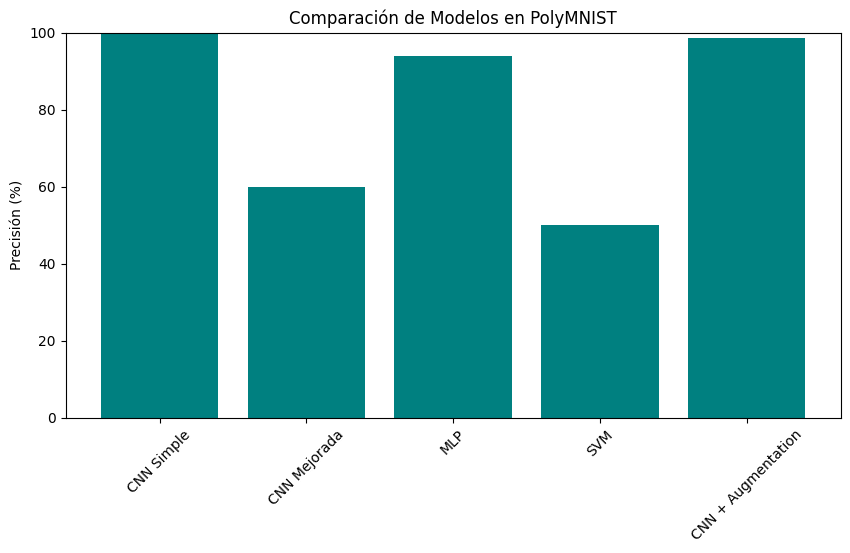

In [ ]:
acc_cnn_simple = 99.78     # CNN simple
acc_cnn_mejorada = 60.0    # CNN mejorada (model2)
acc_mlp = 93.91            # MLP
acc_svm = 50             # SVM con embeddings
acc_aug = 98.56            # CNN con augmentation

# === Lista para el gráfico ===
model_names = ["CNN Simple", "CNN Mejorada", "MLP", "SVM", "CNN + Augmentation"]
accuracies = [acc_cnn_simple, acc_cnn_mejorada, acc_mlp, acc_svm, acc_aug]


plt.figure(figsize=(10,5))
plt.bar(model_names, accuracies, color='teal')
plt.ylabel("Precisión (%)")
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.title("Comparación de Modelos en PolyMNIST")
plt.show()


Descripción de los modelos implementados

CNN Simple (model)

* Arquitectura: Conv2D(32) → MaxPooling → Conv2D(64) → MaxPooling → Dense(128) → Softmax.

* Trabaja con imágenes de 28×28 y extrae patrones espaciales mediante convoluciones.

* Logró un alto rendimiento debido a su capacidad de reconocer bordes y formas locales de los dígitos.

CNN Mejorada (model2)

* Arquitectura más profunda con SeparableConv2D, BatchNormalization y Dropout, trabajando con imágenes 64×64.

* A pesar de ser más compleja, sufrió problemas de sobreajuste y no logró una buena generalización.

MLP (Red Neuronal Simple)

* Arquitectura: Flatten → Dense(512) → Dense(256) → Softmax.

* Aplana la imagen, perdiendo la información espacial.

* Es menos eficiente para datos de imágenes, aunque obtuvo buenos resultados comparado con SVM.

SVM (Support Vector Machine) con embeddings

* Usó características extraídas de la penúltima capa de la CNN avanzada (model2).

* El SVM intentó separar las clases usando un kernel RBF, pero al basarse en embeddings poco discriminativos, su rendimiento fue limitado.

CNN con Data Augmentation

* Misma arquitectura que la CNN simple, pero entrenada con técnicas de aumento de datos (rotación, zoom, flips).

* Esto ayudó a mejorar la capacidad de generalización, aunque su accuracy bajó ligeramente.

Comparación y análisis

* La CNN Simple fue el modelo más efectivo, logrando 99.78% de precisión, confirmando que incluso una arquitectura sencilla de convoluciones es suficiente para el dataset PolyMNIST.

* La CNN Mejorada no superó al modelo simple, probablemente por sobreajuste y una configuración no óptima.

* El MLP obtuvo un rendimiento aceptable (93.91%) pero inferior a las CNN, ya que no captura relaciones espaciales.

* El SVM, aunque es un clasificador robusto, dependió de los embeddings de una CNN poco generalizada, logrando solo 50%.

* El Data Augmentation en la CNN permitió obtener un modelo más robusto, con 98.56%, ideal para pruebas con imágenes nuevas aunque con una leve reducción en accuracy.